In [1]:
# This cell makes sure modules are auto-loaded when you change external python files
%load_ext autoreload
%autoreload 2

# Content Filtering Recommendation System

This notebook implements a basic content filtering recommendation system using automatically generated categories from the tags of books. The core idea is to recommend books that have similar tags to the ones the user has liked. This is achieved by calculating the similarity between tags using the dot product between the categories of a book and the categories liked by the users. 

For more information on how categories are determined, refer to the notebook `preprocess_categories.ipynb`.


In [2]:
import numpy as np
import pandas as pd

Import all the necessary datasets and libraries.

In [3]:
import ast

def parse_array(column):
    return column.apply(lambda x: ast.literal_eval(x))

df_tags = pd.read_csv('./data/new/tags_processed.csv', converters={'categories': ast.literal_eval})

In [4]:
df_books = pd.read_csv('./data/books.csv')
df_ratings = pd.read_csv('./data/ratings.csv')
df_book_tags = pd.read_csv('./data/book_tags.csv')
df_to_read = pd.read_csv('./data/to_read.csv')
df_categories = pd.read_csv('./data/new/categories_small.csv')

Process the books to keep only useful columns.

In [82]:
drop = ['isbn', 'isbn13', 'image_url', 'small_image_url', 'book_id', 'best_book_id', 'original_title', 'ratings_count']
df_books.drop(drop, axis=1, inplace=True)
df_books['book_id']=df_books['work_id']
df_books.drop('work_id', axis=1, inplace=True)
df_books['original_publication_year'] = df_books['original_publication_year'].fillna(0).astype(int)
df_books['language_code'] = ['en' if x in ['eng', 'en-US', 'en-GB', 'en-CA', 'en'] else x for x in df_books['language_code']]
df_books['language_code'] = df_books['language_code'].fillna('unknown')
df_books.info()
df_books.to_csv('./data/new/books_processed.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   goodreads_book_id          10000 non-null  int64  
 1   books_count                10000 non-null  int64  
 2   authors                    10000 non-null  object 
 3   original_publication_year  10000 non-null  int32  
 4   title                      10000 non-null  object 
 5   language_code              10000 non-null  object 
 6   average_rating             10000 non-null  float64
 7   work_ratings_count         10000 non-null  int64  
 8   work_text_reviews_count    10000 non-null  int64  
 9   ratings_1                  10000 non-null  int64  
 10  ratings_2                  10000 non-null  int64  
 11  ratings_3                  10000 non-null  int64  
 12  ratings_4                  10000 non-null  int64  
 13  ratings_5                  10000 non-null  int6

In [46]:
df_book_tags.head()

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716


In [47]:
df_tags.head()

,tag_id,tag_name,categories
0,0,,[other]
1,1,1,[other]
2,2,10,[other]
3,3,12,[other]
4,4,122,[other]


Find now the categories of the books from the tags.

In [5]:
df_book_tags_cat = pd.merge(df_book_tags, df_tags, on='tag_id')
df_book_tags_cat['categories'] = df_book_tags_cat['categories']
df_book_tags_cat.head()

,goodreads_book_id,tag_id,count,tag_name,categories
0,1,30574,167697,read,[other]
1,1,11305,37174,fantasy,[fantasy]
2,1,11557,34173,favorites,[favorite]
3,1,8717,12986,currently reading,[reading]
4,1,33114,12716,young adult,"[adult, young]"


In [6]:
#normalize the tag counts by sum of counts for each book
df_book_tags_cat['tag_count_norm'] = df_book_tags_cat.groupby('goodreads_book_id')['count'].transform(lambda x: x / x.sum())
df_book_tags_cat.head(10)

,goodreads_book_id,tag_id,count,tag_name,categories,tag_count_norm
0,1,30574,167697,read,[other],0.466542
1,1,11305,37174,fantasy,[fantasy],0.103420
2,1,11557,34173,favorites,[favorite],0.095071
3,1,8717,12986,currently reading,[reading],0.036128
4,1,33114,12716,young adult,"[adult, young]",0.035377
5,1,11743,9954,fiction,[fiction],0.027693
6,1,14017,7169,harry potter,[other],0.019945
7,1,5207,6221,books,[other],0.017307
8,1,22743,4974,owned,[own],0.013838
9,1,32989,4364,ya,[other],0.012141


For each book we want to have a list of categories, so we will create a new column `dict_cat` that will contain a list of categories for each book with the count of each time a user has tagged the book with that category.

In [7]:
df_book_tags_cat['dict_cat'] = None
for row in df_book_tags_cat.iterrows():
    dict = {}
    for cat in row[1]['categories']:
        dict[cat] = row[1]['tag_count_norm']
    df_book_tags_cat.at[row[0], 'dict_cat'] = dict

In [8]:
from collections import defaultdict
def merge_dicts(dicts):
    merged = defaultdict(int)
    for d in dicts:
        for k, v in d.items():
            merged[k] += v
    return merged

df_book_cat = df_book_tags_cat.groupby('goodreads_book_id')['dict_cat'].apply(merge_dicts).reset_index()

We have now a dataframe with for a book it list the categories and percentage of users that have tagged the book with that category on the total number of users that have tagged the book.

In [9]:
print(df_book_cat.head())

   goodreads_book_id   level_1  dict_cat
0                  1     other  0.569091
1                  1   fantasy  0.113611
2                  1  favorite  0.106224
3                  1   reading  0.036128
4                  1     adult  0.036534


In [10]:
new = df_book_cat.copy()
#delete the 'other' category because we do not want to recommend books from this category
new = df_book_cat[df_book_cat['level_1'] != 'other']
new = new.dropna()
new.to_csv('./data/new/book_categories_num.csv', index=False)

In [12]:
list_cat = df_categories['word'].tolist()
list_cat[:10]

['fiction',
 '2010s',
 'fantasy',
 'romance',
 'novel',
 'thriller',
 'manga',
 'mystery',
 'literature',
 'light']

For each category we will calculate the percentage of users that have tagged the book with that category on the total number of users that have tagged the book, and create a vector of categories for each book. We will have the same order categories for all books, with a 0 if the book is not tagged with that category.

In [13]:
book_cat_df = df_book_cat.copy()

# List of categories in the special order
special_order = list_cat

# Pivot the DataFrame
df_pivot = book_cat_df.pivot(index='goodreads_book_id', columns='level_1', values='dict_cat').fillna(0)

# Reorder columns based on the special order list
df_pivot = df_pivot[special_order]

# Create the categories and categories_vector columns
df_pivot['categories'] = df_pivot.apply(lambda row: [cat for cat in special_order if row[cat] > 0], axis=1)
df_pivot['categories_vector'] = df_pivot.apply(lambda row: [row[cat] for cat in special_order], axis=1)

# Reset the index to get goodreads_book_id back as a column
book_num_list_cat = df_pivot.reset_index()

# Keep only the required columns
book_num_list_cat = book_num_list_cat[['goodreads_book_id', 'categories', 'categories_vector']]

print(book_num_list_cat)


level_1  goodreads_book_id                                         categories  \
0                        1  [fiction, 2010s, fantasy, romance, novel, myst...   
1                        2  [fiction, 2010s, fantasy, romance, novel, myst...   
2                        3  [fiction, 2010s, fantasy, novel, mystery, lite...   
3                        5  [fiction, 2010s, fantasy, novel, mystery, lite...   
4                        6  [fiction, 2010s, fantasy, novel, mystery, lite...   
...                    ...                                                ...   
9995              31538647  [fiction, 2010s, fantasy, novel, child, series...   
9996              31845516  [fiction, 2010s, adult, favorite, biography, m...   
9997              32075671  [fiction, 2010s, romance, novel, adult, favori...   
9998              32848471  [fiction, 2010s, romance, adult, kid, favorite...   
9999              33288638  [fiction, 2010s, romance, child, adult, kid, f...   

level_1                    

In [14]:
book_num_list_cat.head()
#rescale the categories_vector
book_num_list_cat['categories_vector'] = book_num_list_cat['categories_vector'].apply(lambda x: [i/sum(x) for i in x])
book_num_list_cat.head()

level_1,goodreads_book_id,categories,categories_vector
0,1,"[fiction, 2010s, fantasy, romance, novel, myst...","[0.06020735380148636, 0.007919311854050657, 0...."
1,2,"[fiction, 2010s, fantasy, romance, novel, myst...","[0.05488864476180966, 0.02115250174772796, 0.1..."
2,3,"[fiction, 2010s, fantasy, novel, mystery, lite...","[0.05157336808184686, 0.014717638979379815, 0...."
3,5,"[fiction, 2010s, fantasy, novel, mystery, lite...","[0.05639876972452526, 0.012684827876055476, 0...."
4,6,"[fiction, 2010s, fantasy, novel, mystery, lite...","[0.07986084375721855, 0.016253561153848847, 0...."


In [15]:
book_num_list_cat.to_csv('./data/new/book_categories_num.csv', index=False)

### Book Visualization

We will now visualize the books in a 2D space using TSNE. We will look at how for example books with the category "manga" are grouped together. 

In [16]:
Y = [1 if 'manga' in book_num_list_cat['categories'][i] else 0 for i in range(len(book_num_list_cat))]

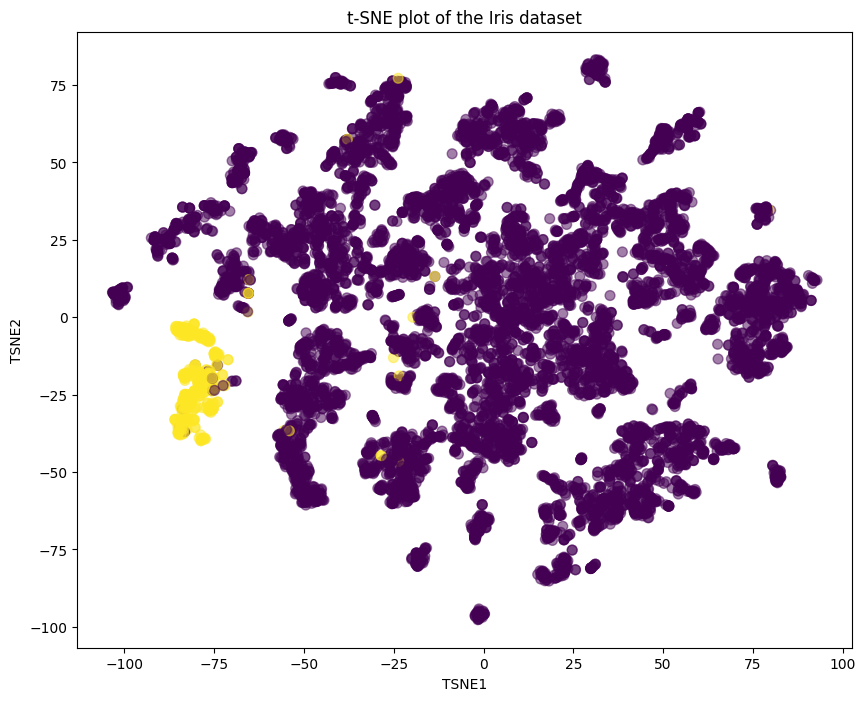

In [17]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


X = np.array(book_num_list_cat['categories_vector'].tolist())
y = Y

# Fit and transform the data using t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Create a DataFrame with the t-SNE results
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['label'] = y

# Plot the t-SNE results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_tsne['TSNE1'], df_tsne['TSNE2'], c=df_tsne['label'], cmap='viridis', s=50, alpha=0.5)
# plt.colorbar(scatter, ticks=[0, 1, 2])
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.title('t-SNE plot of the Iris dataset')
plt.show()

We can see that the books that are tagged with the category "manga" are grouped together. This is a good sign that the categories are well defined and that we can use them to recommend books.

## Feature creation for users

First we split the ratings into train and test set.

In [186]:
from sklearn.model_selection import train_test_split
ratings = pd.read_csv('./data/ratings.csv')
train_df, test_df = train_test_split(ratings, test_size=0.2, random_state=42)
train_df.to_csv('./data/new/ratings_train.csv', index=False)
test_df.to_csv('./data/new/ratings_test.csv', index=False)

In [57]:
book_num_list_cat = pd.read_csv('./data/new/book_categories_num.csv')

In [ ]:
df_ratings = pd.read_csv('./data/new/ratings_train.csv')

In [ ]:
df_books_pre = pd.read_csv('./data/new/books_processed.csv')

We will now take the `goodreads_book_id` and `book_id` to be able to merge the ratings with the books.

In [20]:
#new df with only the columns we need goodreads_book_id and book_id
df_books_pre = df_books_pre[['goodreads_book_id', 'book_id']]
df_books_pre.head()

,goodreads_book_id,book_id
0,2767052,2792775
1,3,4640799
2,41865,3212258
3,2657,3275794
4,4671,245494


In [21]:
df_ratings = pd.merge(df_ratings, df_books_pre, on='book_id')
df_ratings.head()

,user_id,book_id,rating,goodreads_book_id
0,37935,764,5,15566
1,50151,696,4,77773
2,8356,1759,5,30852
3,10020,817,4,8908
4,50572,696,3,77773


Then we rescale the ratings to have positive and negative ratings. Like that users features will be positive or negative depending on the rating they gave to the book. If we kept the ratings as they are, the features would be positive no matter if the user liked or disliked the book.

In [22]:
#rescale the ratings
dict = {'1' : -2, '2' : -1, '3' : 1, '4' : 2, '5' : 3}
df_ratings['rating'] = df_ratings['rating'].apply(lambda x: dict[str(x)])

In [23]:
df_ratings = pd.merge(df_ratings, book_num_list_cat, on='goodreads_book_id')

In [ ]:
import ast
vector = df_ratings['categories_vector'][0]
array = ast.literal_eval(vector)

categories_num = []
for row in df_ratings['categories_vector']:
    categories_num.append(ast.literal_eval(row))
df_ratings['categories_vector'] = categories_num

In [25]:
df_ratings.head()

,user_id,book_id,rating,goodreads_book_id,categories,categories_vector
0,37935,764,3,15566,"[fiction, fantasy, novel, series, scifi, adult...","[0.11574074074074077, 0.0, 0.40833333333333355..."
1,50151,696,2,77773,"[fiction, 2010s, fantasy, romance, novel, myst...","[0.20058565153733526, 0.0026842362127867253, 0..."
2,8356,1759,3,30852,"[fiction, 2010s, fantasy, novel, literature, g...","[0.20012177795818956, 0.0038563020093363093, 0..."
3,10020,817,2,8908,"[fiction, 2010s, fantasy, novel, thriller, lit...","[0.21860199523025758, 0.02401666050854858, 0.0..."
4,50572,696,1,77773,"[fiction, 2010s, fantasy, romance, novel, myst...","[0.20058565153733526, 0.0026842362127867253, 0..."


We multiply the categories_vector by the rating and then sum all the vectors for each user. This will give us a vector of categories for each user in which we will have sum of categories scores for each user.

In [ ]:
multiplied_vec = []
for i in range(len(df_ratings)):
    multiplied_vec.append(np.multiply(df_ratings['categories_vector'][i], df_ratings['rating'][i]))
df_ratings['multiplied_vec'] = multiplied_vec

We have now a dataframe with for each users the categories they like the most and the categories they dislike.

In [27]:
users = df_ratings.groupby('user_id')['multiplied_vec'].apply(lambda x: sum(x)).reset_index()
users = users.rename(columns={"multiplied_vec": "categories_vector"})
users.head()

,user_id,categories_vector
0,1,"[0.2881355932203389, 0.0, 0.0, 0.0395480225988..."
1,2,"[1.1567733156947955, 0.0018079336382005736, 0...."
2,3,"[-1.0776908484325634, -0.01552172527222519, -0..."
3,4,"[1.193350697890925, 0.013956107144568498, 0.0,..."
4,5,"[0.2009925558312655, 0.0, 1.8498759305210921, ..."


In [29]:
list_cat = df_categories['word'].tolist()

In [30]:
#find categories for each user
users['categories_liked'] = users['categories_vector'].apply(lambda x: [list_cat[i] for i in range(len(x)) if x[i] > 0])
users['categories_disliked'] = users['categories_vector'].apply(lambda x: [list_cat[i] for i in range(len(x)) if x[i] < 0])

In [31]:
users.head()

,user_id,categories_vector,categories_liked,categories_disliked
0,1,"[0.2881355932203389, 0.0, 0.0, 0.0395480225988...","[fiction, romance, novel, literature, light, a...",[]
1,2,"[1.1567733156947955, 0.0018079336382005736, 0....","[fiction, 2010s, fantasy, romance, novel, myst...",[]
2,3,"[-1.0776908484325634, -0.01552172527222519, -0...",[],"[fiction, 2010s, fantasy, romance, novel, thri..."
3,4,"[1.193350697890925, 0.013956107144568498, 0.0,...","[fiction, 2010s, romance, novel, series, histo...",[]
4,5,"[0.2009925558312655, 0.0, 1.8498759305210921, ...","[fiction, fantasy, romance, novel, child, grap...",[]


In [32]:
#rename the column
users.to_csv('./data/new/user_categories_num.csv', index=False)

## Search cluster in users

We want to see if like for the books, the users are grouped together in a 2D space. We will use TSNE to visualize the users in a 2D space.

We will use once again the "manga" category to see if the users that like manga are grouped together.

In [33]:
Y = [1 if 'manga' in users['categories_liked'][i] else 0 for i in range(len(users))][:10000]

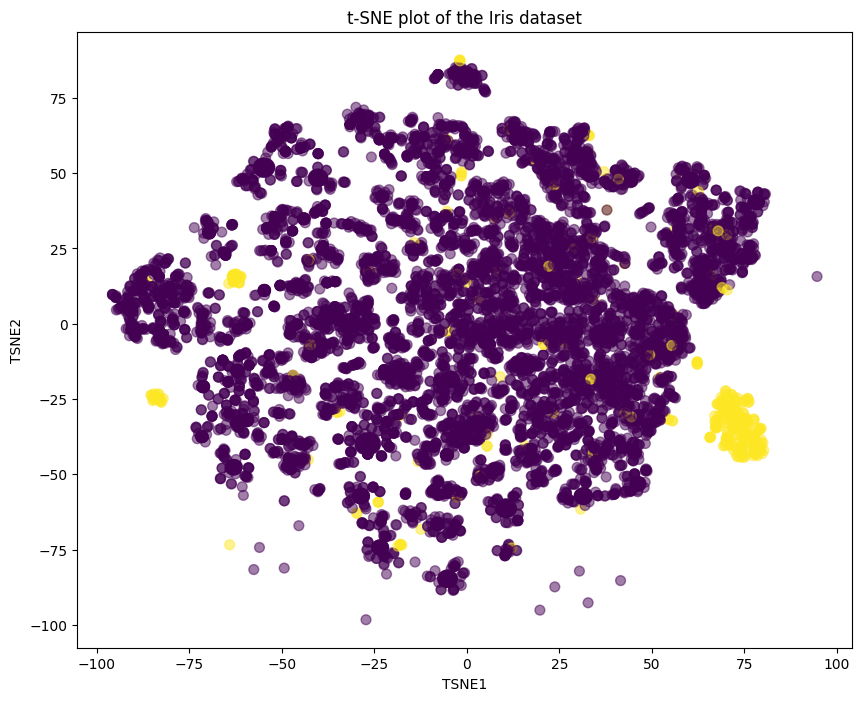

In [34]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


X = np.array(users['categories_vector'].tolist())[:10000]
y = Y#df_book_cat['goodreads_book_id']

# Fit and transform the data using t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Create a DataFrame with the t-SNE results
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['label'] = y

# Plot the t-SNE results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_tsne['TSNE1'], df_tsne['TSNE2'], c=df_tsne['label'], cmap='viridis', s=50, alpha=0.5)
# plt.colorbar(scatter, ticks=[0, 1, 2])
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.title('t-SNE plot of the Iris dataset')
plt.show()

We can see that the users that like manga are grouped together. This is a good sign that we can use the categories to recommend books.

## Recommendation System
For the ratings of the test set we want to see if we can predict the rating value based on the categories of the book and the categories that the user likes.


In [35]:
ratings_test = pd.read_csv('./data/new/ratings_test.csv')
ratings_test.head()

,user_id,book_id,rating
0,42562,2757,3
1,43232,134,4
2,37244,1463,5
3,53366,71,2
4,29634,3339,4


In [36]:
ratings_test = pd.merge(ratings_test, df_books_pre, on='book_id')
ratings_test = pd.merge(ratings_test, users, on='user_id')
ratings_test.rename(columns={'categories_vector': 'user_categories_vector', 'categories_liked': 'user_categories_liked', 'categories_disliked': 'user_categories_disliked'}, inplace=True)
ratings_test = pd.merge(ratings_test, book_num_list_cat, on='goodreads_book_id')
ratings_test.rename(columns={'categories_vector': 'book_categories_vector', 'categories': 'book_categories'}, inplace=True)
ratings_test.head()

,user_id,book_id,rating,goodreads_book_id,user_categories_vector,user_categories_liked,user_categories_disliked,book_categories,book_categories_vector
0,41122,2384,5,84136,"[0.9498065402527603, 0.027486437613019898, 0.0...","[fiction, 2010s, fantasy, novel, literature, s...",[],"[fiction, 2010s, fantasy, romance, series, sci...","[0.014950304852584986, 0.014115092290988061, 0..."
1,40374,2506,4,17174,"[1.087360104811731, 0.04516477227915723, 0.205...","[fiction, 2010s, fantasy, novel, literature, c...",[],"[fiction, 2010s, novel, literature, adult, fav...","[0.297969875573019, 0.017026850032743943, 0.0,..."
2,3876,1781,5,6159,"[0.3269548872180451, 0.0338345864661654, -0.85...","[fiction, 2010s, novel, thriller, mystery, lit...","[fantasy, romance, child, scifi, kid, science,...","[fiction, 2010s, fantasy, novel, literature, a...","[0.27789699570815446, 0.00858369098712446, 0.0..."
3,52409,1142,4,41913,"[0.9519354213949968, 0.01184493898061737, 0.0,...","[fiction, 2010s, romance, novel, literature, g...",[],"[fiction, 2010s, fantasy, novel, thriller, mys...","[0.2829229547259731, 0.003812549642573472, 0.0..."
4,50485,141,3,11525,"[0.85094852904015, 0.013032935746066787, 0.617...","[fiction, 2010s, fantasy, romance, novel, lite...",[],"[fiction, literature, history, adult, favorite...","[0.17916999201915396, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [ ]:
categories_num = []
for row in ratings_test['book_categories_vector']:
    categories_num.append(ast.literal_eval(row))
ratings_test['book_categories_vector'] = categories_num

We know use a dot product to calculate the similarity between the categories of the book and the categories that the user likes. We will use this similarity to predict the rating of the user for the book.

In [38]:
ratings_test['predicted_rating'] = None
for i in range(len(ratings_test)):
    ratings_test.at[i, 'predicted_rating'] = np.dot(ratings_test['user_categories_vector'][i], ratings_test['book_categories_vector'][i])

In [39]:
ratings_test.head(20)

,user_id,book_id,rating,goodreads_book_id,user_categories_vector,user_categories_liked,user_categories_disliked,book_categories,book_categories_vector,predicted_rating
0,41122,2384,5,84136,"[0.9498065402527603, 0.027486437613019898, 0.0...","[fiction, 2010s, fantasy, novel, literature, s...",[],"[fiction, 2010s, fantasy, romance, series, sci...","[0.014950304852584986, 0.014115092290988061, 0...",0.076925
1,40374,2506,4,17174,"[1.087360104811731, 0.04516477227915723, 0.205...","[fiction, 2010s, fantasy, novel, literature, c...",[],"[fiction, 2010s, novel, literature, adult, fav...","[0.297969875573019, 0.017026850032743943, 0.0,...",0.439164
2,3876,1781,5,6159,"[0.3269548872180451, 0.0338345864661654, -0.85...","[fiction, 2010s, novel, thriller, mystery, lit...","[fantasy, romance, child, scifi, kid, science,...","[fiction, 2010s, fantasy, novel, literature, a...","[0.27789699570815446, 0.00858369098712446, 0.0...",0.094017
3,52409,1142,4,41913,"[0.9519354213949968, 0.01184493898061737, 0.0,...","[fiction, 2010s, romance, novel, literature, g...",[],"[fiction, 2010s, fantasy, novel, thriller, mys...","[0.2829229547259731, 0.003812549642573472, 0.0...",0.404125
4,50485,141,3,11525,"[0.85094852904015, 0.013032935746066787, 0.617...","[fiction, 2010s, fantasy, romance, novel, lite...",[],"[fiction, literature, history, adult, favorite...","[0.17916999201915396, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.321457
5,41848,2647,5,71252,"[0.47675180091683034, 0.005239030779305828, 0....","[fiction, 2010s, romance, novel, series, histo...",[],"[fiction, 2010s, fantasy, novel, manga, litera...","[0.029352308563111502, 0.00517506266677448, 0....",0.035466
6,30366,1631,5,109520,"[2.019380191151166, 0.028796547437845023, 0.04...","[fiction, 2010s, fantasy, romance, novel, myst...",[],"[fiction, 2010s, romance, adult, favorite, bio...","[0.17351318209687305, 0.015328019619865114, 0....",0.616866
7,19527,87,4,8155,"[1.1047177817720772, 0.0088043965026919, 0.017...","[fiction, 2010s, fantasy, romance, novel, thri...",[],"[fiction, 2010s, romance, novel, series, histo...","[0.23837590045841517, 0.002619515389652914, 0....",0.511894
8,11388,742,4,11312,"[0.8563678599381943, 0.021438618438856652, 0.1...","[fiction, 2010s, fantasy, romance, novel, myst...",[],"[fiction, 2010s, fantasy, novel, mystery, lite...","[0.09203655352480417, 0.0040469973890339414, 0...",0.181978
9,449,362,4,61794,"[0.7151277013752455, 0.007858546168958742, 0.0...","[fiction, 2010s, romance, novel, series, histo...",[],"[fiction, 2010s, novel, literature, favorite, ...","[0.08333333333333334, 0.01801801801801802, 0.0...",0.170856


We rescale the ratings as we did for the users features.

In [46]:
dict = {'1' : -2, '2' : -1, '3' : 0, '4' : 1, '5' : 2} 
ratings_test['rating_norm'] = ratings_test['rating'].apply(lambda x: dict[str(x)])

In [47]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(ratings_test['rating_norm'], ratings_test['predicted_rating'])
print(f"Test MSE: {mse}")

Test MSE: 1.4668255230382672


In [6]:
rmse = np.sqrt(mse)
print(f"Test RMSE: {rmse}")

Test RMSE: 1.2111257255290497


We can see that the predicted ratings are 1.21 change on average from the true ratings. This means we can not predict the ratings accurately, but we can predict if the user will like or dislike the book.